# Локализация в PSLG методом полос

   Перед нами стоит одна из классических задач вычислительной геометрии: необходимо по данной точке определить какому фейсу она принадлежит.
Для решения воспользуемся следующей идей: сначала локализуемся по координате $X$, а затем по координате $Y$.
Для этого через каждую точку $PSLG$ проведем прямую. В итоге мы разбили всю плоскость на полосы.

![Пример разбиения плоскости](images/SLABS.png)

   Теперь отсортируем полосы по координате $X$. 
Это позволит нам с помощью двоичного поиска за $O(\log{n})$ найти полосу, в которую попала точка запроса.
Заметим, что по построению ребра могут пересекаться только на границах полос.
Следовательно внутри одной полосы ребра вертикально упорядочены.
Значит мы можем хранить для каждой полосы, например, дерево поиска и за $O(\log{n})$ локализоваться в ней.
   
   Рассмотрим локализацию в полосе несколько подробнее.
Задача состоит в том, чтобы определить какое ребро выше, а какое ниже точки запроса(зная это, можно однозначно определить какому фейсу принадлежит точка).
   
### Упражнение
   Вам необходимо реализовать алгоритм локализации в полосе.
Для этого вам необходимо реализовать функцию <b>locate</b>.
Она принимает два аргумента:

* <b>point</b> – точка запроса(точка представляет из себя список из двух элементов – координаты $X$ и координаты $Y$)
* <b>edges</b> – список ребер, где каждое ребро – это список из двух точек

Вы можете пользоваться методом <b>turn(a, b, c)</b> из <b>test_utils</b>, который считает поворот точки $c$ относительно отрезка $ab$ и возвразвращает:

* $1$, если поворот левый
* $0$ , если они лежат на одной прямой
* $-1$ , если поворот правый

Функция должна возвращать кортеж $(i, j)$, где $i$ – индекс ребра снизу, а $j$ – сверху.
Если ребра снизу нет, то $i$ должен быть равен $-1$.
Если отсутсвует верхнее ребро, то $j$ должен быть равен $len(edges)$.

Это интерактивная модель, поэтому Вы можете проверить корректность решения, просто сделав несколько кликов внутри полосы.

<IPython.core.display.Javascript object>


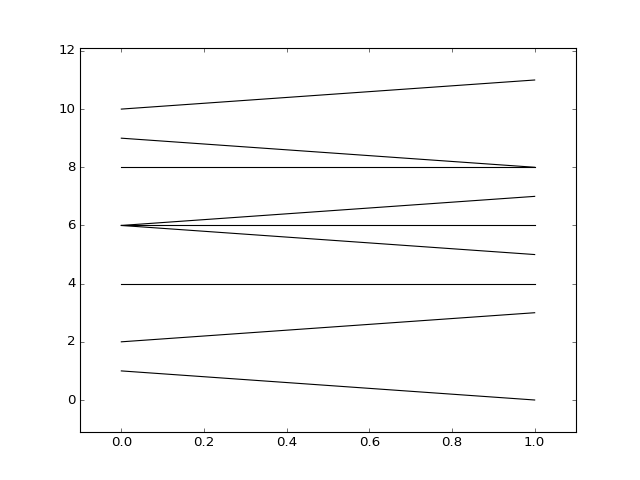

In [4]:
%matplotlib notebook
from test_utils import *

slab = Slab.read_slab("sample01.txt")


def locate(edges, point):
    # Сейчас тут стоит заглушка, чтобы не отрисовывать красным никакие ребра
    # Напоминание: в python целочисленное деление выполняется оператором //
    return None


def on_click(event):
    fig.clear()
    point = [event.xdata, event.ydata]
    loc = locate(slab.edges, point)
    slab.draw(loc, point)
    
fig, ax = plt.subplots()
fig.canvas.mpl_connect('button_press_event', on_click)
slab.draw()


   Сейчас вы уже умеете искать нужную полосу и локализовываться в ней.
Теперь немного поговорим о том, как построить сами полосы.

Рассмотрим две соседние полосы.
Заметим, что полоса справа отличается от полосы слева тем, что в ней появились и исчезли какие-то отрезки.
Значит следующую полосу можно получить, если добавить в неё новые отрезки и удалить исчезнувшие.
Следовательно для одного отрезка(ребра) у нас есть события двух типов:

* <b>insert</b>, когда мы его вставляем
* <b>delete</b>, когда мы уго удаляем

Тогда заведем приоритетную очередь, в которую положим все эти события.
Так как событие происходит в какой-то точке, то сравнивать события мы будем, как точки.
Событию вставки будет соответствовать начало отрезка, а конец удалению.
Сами точки сравниваются лексикографически.
Следовательно алгоритм становится следующим: добавим все события в приоритетную очередь, будем по очереди доставать события и выполнять их. При этом понятно, что если $X$ координата события не совпадает с $X$ координатой текущей полосы, то это событие уже относится к новой полосе.

В следующей ячейке следует возможная реализация алгоритма построения локализационный структуры.

In [2]:
import utils

def createSearchingDataStructure(edges: list):
    currentSlab = SortedSet()
    events = list()
    slabs = list()

    for e in edges:
        events.append(Event(e.origin, e, Event.EventType.INSERT))
        events.append(Event(e.destination, e, Event.EventType.DELETE))

    heapq.heapify(events)
        
    while len(events) != 0:
        event = heapq.heappop(events)

        if len(slabs) == 0 or (event.x, currentSlab) != slabs[-1]:
            currentSlab = currentSlab.copy()
            slabs.append((event.x, currentSlab))

        if event.type == Event.EventType.INSERT:
            currentSlab.add(event.edge)
        elif event.type == Event.EventType.DELETE:
            currentSlab.remove(event.edge)
        else:
            raise Exception('Unknown event type')
    return slabs


<img src="images/worst_case.png" align="right"/>

   Отлично! Мы получили работающий алгоритм, однако несложно придумать случай, когда он будет использовать $O(n^2)$ памяти. 
   
   Например, рассмотрим отрезки вида $S_i = a_i b_i$, где $a_i = (0, i)$ и $b_i = (i, i)$ для $i = 1 \dots n$. (см. рисунок)

   Это последовательность горизонтальных отрезков.
Если использовать данный алгоритм, то в первой полосе будет $n$ отезков, а в каждой следующей на один меньше чем в предыдущей.
А так как $1 + 2 + 3 + \dots + n = O(n^2)$, то в таком случае будет использованно $O(n^2)$ памяти.

Далее мы будем модифицировать алгоритм, чтобы уменьшить потребление памяти.

## Персистентные деревья

   Для того чтобы улучшить использование памяти нам понадобятся персистентные деревья поиска.
   
   Давайте рассмотрим $X$ - координату как время.
Двигаясь вправо по $X$, мы движемся во времени.
Пусть у нас есть изначально пустое дерево поиска.
Когда мы встречаем начало отрезка, мы добавляем его в дерево с текущей $Y$ - координатой.
Когда мы встречаем конец отрезка, удаляем его из дерева (если отрезок(ки) лежит(ат) на вертикальной прямой, события начала/конца сортируются по $Y$, а если один отрезок заканчивается, а другой начинается в одной и той же точке, событие начала идет раньше).
   
   Вернемся к первоначальной задаче.
Применем к полосам метафору времени: одна полоса - это отрезок времени, когда ничего не происходило.
То есть, на одну полосу приходится одна версия персистентного дерева (а не отдельное дерево поиска, как раньше).
С точки зрения операции поиска ничего не изменилось(теперь мы просто ищем по координате $X$ версию дерева поиска, а дальше наш алгоритм не изменился).

   А вот потребление памяти уменьшилось до $O(n\log{n})$ - так как в персистентном дереве при операции добавления/удаления прибавляется $O(\log{n})$ памяти (копируются узлы на пути от корня до вставленной/удаленной вершины + $O(1)$ на перебалансировку), а так как отрезков $O(n)$, то всего таких операций будет тоже $O(n)$.

In [3]:
def insert_persistent(v, value):
    """
    Эта функция осуществляет вставку элемента в персистентное двоичное дерево поиска.
    Каждая вершина имеет поле 'version', которое присваевается в конструкторе.
    Все узлы на пути от корня, до вставленной вершины копируются.
    Функция возвращает новый корень дерева.
    """

    if v.data < value:
        if v.right is None:
            """Создаем новую версию дерева"""
            Node.increase_version()
            result = v.copy()
            result.right = Node(value)
            return result
        else:
            right = insert_persistent(v.right, value)
            result = v.copy()
            result.right = right
            return result
    elif v.data > value:
        if v.left is None:
            """Создаем новую версию дерева"""
            Node.increase_version()
            result = v.copy()
            result.left = Node(value)
            return result
        else:
            left = insert_persistent(v.left, value)
            result = v.copy()
            result.left = left
            return result
    else:
        return v

## Частично персистентные деревья

   Оказывается, что использование памяти можно свести к $O(n)$.
   Используем тот факт, что нам не нужна полная персистентность (возможность менять и читать все версии). Нам достаточно только частичной (возможность менять и получать новые версии только из последней, но делать запросы можно по всем). Чтобы понять идею, попробуем сначала сделать что-нибудь попроще, но такое же модное - частично персистентный список, например.
   
   Давайте в узле списка хранить не один указатель на следующий элемент, а два - $next$ и $next2$. Дополнительно мы будем хранить номер первой версии списка, начиная с которой используется указатель $next2$. Также мы будем поддерживать таблицу (хэшмап или массив), с помощью которого по версии будем получать указатель на начало списка.

   Пусть мы хотим вставить очередной элемент в такой список между элементами $i$ и $i + 1$ – создать новую версию под номером $k$. Мы начинаем идти от корня, соответствующего версии $k − 1$ до элемента $i$. Всякий раз мы выбираем соответствующий самой свежей версии указатель из двух (это всегда будет $next2$, если он не $null$). Пусть мы дошли до $i$ -го узла. Если его указатель $next2$ пуст, мы создаем новую вершину, указатель $next$ которой мы подвешиваем на $i + 1$, а указатель $i.next2$ подвешиваем к новой вершине. В противном случае нам придется скопировать $i$ и всех его предков до тех пор, пока мы не встретим предка со свободным указателем $next2$.
   
   В следующей ячейке написана возможная реализация вставки в частично персистентный односвязный список.

In [5]:
class HalfPersistentNode:
    """Узел списка"""
    def __init__(self, data, version):
        self.next = None
        self.next2 = None
        self.data = data
        self.version = version
        
def insert_after(v, i, data, new_version):
    if i == 0:
        """Дошли до места вставки"""
        node = HalfPersistentNode(data, new_version)
        if v.next is None:
            v.next = node
            return v
        elif v.next2 is None:
            node.next = v.next
            v.next2 = node
            return v
        else:
            copy = HalfPersistentNode(v.data, new_version)
            copy.next = node
            return copy
    else:
        if v.next2 is not None:
            result = insert_after(v.next2, i - 1, data, new_version)
            if v.next2 != result:
                """сохранить в next2 нельзя, поэтому копируем вершину"""
                copy = HalfPersistentNode(v.data, new_version)
                copy.next = result
                return copy
            else:
                return v
        else:
            retult = insert_after(v.next, i - 1, data, new_version)
            if v.next != result:
                v.next2 = result
            return v

   Такую же тактику применим в деревьях: добавим в каждый узел дерева по дополнительному указателю $next$ и номер версии + флажок направления: влево или вправо смотрит $next$. Балансировочную информацию (размер поддерева или там цвет вершины) в вершине мы будем нещадно перезаписывать, потому что эта информация может быть актуальна только для последней версии (все предыдущие версии дерева сбалансированны).
   
### Утверждение
> Вышеописанное частично персистентное дерево использует $O(n)$ памяти<br>

$\triangleright$<br>
<div style="padding-left:40px">
В худшем случае, конечно же, нам придется копировать $O(\log{n})$ узлов, но мы самортизируем эту оценку.
<br>
Заметим, что копируем мы только те узлы, в которых уже занят указатель $next$. Давайте будем платить $2$ монетки за обновление указателя $next$ и версии в узле: одну за саму операцию, а другую отложим в узел про запас. Таким образом, в каждом заполненном узле будет лежать запасенная монетка. Когда нам нужно будет скопировать этот узел, мы потратим только уже отложенные монетки.
Таким образом, амортизированная оценка для дополнительной памяти на операцию изменения в дереве – $O(1)$, а так как операций изменения $O(n)$, то и памяти всего требуется $O(n)$.
</div>
$\triangleleft$